# SEGMENTACIÓN DE CLIENTES EN FUNCIÓN DE SU COMPORTAMIENTO DE COMPRA USANDO SPARK

**OBJETIVO**
El objetivo del presente análisis, es mostrar una alternativa a PANDAS, mediante el uso de SPARK. Con el fín de que sea una herramienta potente en el análisis de datos.
Para el presente proyecto, se ha tomado un DataSet, que muestra un conjunto de datos transaccionales que contiene todas las transacciones ocurridas entre el 01/12/2010 y el 09/12/2011 para un comercio minorista en línea (No de forma física) con sede y registro en el Reino Unido. La empresa se dedica principalmente a la venta de regalos únicos para toda ocasión. Muchos de los clientes de la empresa son mayoristas.
En este caso, se realizará una segmentación de los clientes en función de su comportamiento de compra, mediante el método RFM.

In [1]:
from pyspark.sql import SparkSession

In [2]:
# Creando el Spark Session

spark = SparkSession.builder.appName("Tutorial de Pyspark").config("spark.memory.offHeap.enabled","true").config("spark.memory.offHeap.size","10g").getOrCreate()

In [3]:
# Creando el dataframe en spark.

df = spark.read.csv('Online_retail.csv', sep=";", header=True, escape='\"')

In [4]:
# Muestro las primeras 5 filas del dataframe. 0, indica no truncar las columnas o campos.

df.show(5,0)

+---------+---------+-----------------------------------+--------+--------------+---------+----------+--------------+
|InvoiceNo|StockCode|Description                        |Quantity|InvoiceDate   |UnitPrice|CustomerID|Country       |
+---------+---------+-----------------------------------+--------+--------------+---------+----------+--------------+
|536365   |85123A   |WHITE HANGING HEART T-LIGHT HOLDER |6       |1/12/2010 8:26|2,55     |17850     |United Kingdom|
|536365   |71053    |WHITE METAL LANTERN                |6       |1/12/2010 8:26|3,39     |17850     |United Kingdom|
|536365   |84406B   |CREAM CUPID HEARTS COAT HANGER     |8       |1/12/2010 8:26|2,75     |17850     |United Kingdom|
|536365   |84029G   |KNITTED UNION FLAG HOT WATER BOTTLE|6       |1/12/2010 8:26|3,39     |17850     |United Kingdom|
|536365   |84029E   |RED WOOLLY HOTTIE WHITE HEART.     |6       |1/12/2010 8:26|3,39     |17850     |United Kingdom|
+---------+---------+-----------------------------------

## ANÁLISIS EXPLORATORIO DE LOS DATOS

In [5]:
# Cantidad de filas del dataframe.

print('La cantidad de filas es:', df.count()) 

# clientes únicos en el dataframe.

print('Los clientes únicos son:', df.select('CustomerID').distinct().count())

# Cantidad de productos únicos en el dataframe.

print('Los productos únicos son:', df.select('StockCode').distinct().count())

# Cantidad de países únicos en el dataframe.

print('Los paises únicos son:' , df.select('country').distinct().count())

# Cantidad de facturas en el dataframe.

print('La cantidad de transacciones Únicas son:', df.select('InvoiceNo').distinct().count()) 


La cantidad de filas es: 541909
Los clientes únicos son: 4373
Los productos únicos son: 4070
Los paises únicos son: 38
La cantidad de transacciones Únicas son: 25900


In [6]:
# Pasar a pandas para analizar algunos datos
import pandas as pd
pd_df = pd.read_csv('Online_retail.csv', sep=';')
pd_df.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,1/12/2010 8:26,"2,55",17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,1/12/2010 8:26,"3,39",17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,1/12/2010 8:26,"2,75",17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,1/12/2010 8:26,"3,39",17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,1/12/2010 8:26,"3,39",17850.0,United Kingdom


In [7]:
pd_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 541909 entries, 0 to 541908
Data columns (total 8 columns):
 #   Column       Non-Null Count   Dtype  
---  ------       --------------   -----  
 0   InvoiceNo    541909 non-null  object 
 1   StockCode    541909 non-null  object 
 2   Description  540455 non-null  object 
 3   Quantity     541909 non-null  int64  
 4   InvoiceDate  541909 non-null  object 
 5   UnitPrice    541909 non-null  object 
 6   CustomerID   406829 non-null  float64
 7   Country      541909 non-null  object 
dtypes: float64(1), int64(1), object(6)
memory usage: 33.1+ MB


**Valores Nulos**: existen valores nulos en los campos: Description y CustomerID

In [8]:
# Spark trabaja con el formato decimal de "." en este caso, hay que cargar el dataset en un inicio cambiando el formato, 
# o a su vez remplazar las comas por decimales.
from pyspark.sql.functions import *
from pyspark.sql.types import *

df = df.withColumn('UnitPrice', regexp_replace(col('UnitPrice'), ',', '.'))
#Se le da formato a tipo decimal:
df = df.withColumn('UnitPrice', col('UnitPrice').cast(DecimalType(10, 2)))
df.show(10,0)

+---------+---------+-----------------------------------+--------+--------------+---------+----------+--------------+
|InvoiceNo|StockCode|Description                        |Quantity|InvoiceDate   |UnitPrice|CustomerID|Country       |
+---------+---------+-----------------------------------+--------+--------------+---------+----------+--------------+
|536365   |85123A   |WHITE HANGING HEART T-LIGHT HOLDER |6       |1/12/2010 8:26|2.55     |17850     |United Kingdom|
|536365   |71053    |WHITE METAL LANTERN                |6       |1/12/2010 8:26|3.39     |17850     |United Kingdom|
|536365   |84406B   |CREAM CUPID HEARTS COAT HANGER     |8       |1/12/2010 8:26|2.75     |17850     |United Kingdom|
|536365   |84029G   |KNITTED UNION FLAG HOT WATER BOTTLE|6       |1/12/2010 8:26|3.39     |17850     |United Kingdom|
|536365   |84029E   |RED WOOLLY HOTTIE WHITE HEART.     |6       |1/12/2010 8:26|3.39     |17850     |United Kingdom|
|536365   |22752    |SET 7 BABUSHKA NESTING BOXES       

In [9]:
# Consultando valores negativos en Unit Price:
from pyspark.sql.functions import col
df.filter(col('UnitPrice')<0).show()
print('filas:', df.filter(col('UnitPrice')<0).count())

+---------+---------+---------------+--------+---------------+---------+----------+--------------+
|InvoiceNo|StockCode|    Description|Quantity|    InvoiceDate|UnitPrice|CustomerID|       Country|
+---------+---------+---------------+--------+---------------+---------+----------+--------------+
|  A563186|        B|Adjust bad debt|       1|12/8/2011 14:51|-11062.06|      NULL|United Kingdom|
|  A563187|        B|Adjust bad debt|       1|12/8/2011 14:52|-11062.06|      NULL|United Kingdom|
+---------+---------+---------------+--------+---------------+---------+----------+--------------+

filas: 2


In [10]:
# Consultando valores negativos en Quantity:
from pyspark.sql.functions import col
df.filter(col('Quantity')<0).show()
print('filas:', df.filter(col('Quantity')<0).count())

+---------+---------+--------------------+--------+---------------+---------+----------+--------------+
|InvoiceNo|StockCode|         Description|Quantity|    InvoiceDate|UnitPrice|CustomerID|       Country|
+---------+---------+--------------------+--------+---------------+---------+----------+--------------+
|  C536379|        D|            Discount|      -1| 1/12/2010 9:41|    27.50|     14527|United Kingdom|
|  C536383|   35004C|SET OF 3 COLOURED...|      -1| 1/12/2010 9:49|     4.65|     15311|United Kingdom|
|  C536391|    22556|PLASTERS IN TIN C...|     -12|1/12/2010 10:24|     1.65|     17548|United Kingdom|
|  C536391|    21984|PACK OF 12 PINK P...|     -24|1/12/2010 10:24|     0.29|     17548|United Kingdom|
|  C536391|    21983|PACK OF 12 BLUE P...|     -24|1/12/2010 10:24|     0.29|     17548|United Kingdom|
|  C536391|    21980|PACK OF 12 RED RE...|     -24|1/12/2010 10:24|     0.29|     17548|United Kingdom|
|  C536391|    21484|CHICK GREY HOT WA...|     -12|1/12/2010 10:

Como son cantidades negativas, esto quiere decir que se eliminaron los productos.
Para esto, se requiere eliminar los productos negativos y los repetidos positivos, si existiesen.

In [11]:
# Pais del que proceden las compras. Uso de GroupBy().

# Importando la librería de funciones de pyspark, para trabajar con BigData.
# group By(): Agrupar
# agg(): Agregación de datos.

from pyspark.sql.functions import *
from pyspark.sql.types import *

df.groupBy('Country').agg(countDistinct('CustomerID').alias('country_count')).show()

+------------------+-------------+
|           Country|country_count|
+------------------+-------------+
|            Sweden|            8|
|         Singapore|            1|
|           Germany|           95|
|               RSA|            1|
|            France|           87|
|            Greece|            4|
|European Community|            1|
|           Belgium|           25|
|           Finland|           12|
|             Malta|            2|
|       Unspecified|            4|
|             Italy|           15|
|              EIRE|            3|
|         Lithuania|            1|
|            Norway|           10|
|             Spain|           31|
|           Denmark|            9|
|         Hong Kong|            0|
|            Israel|            4|
|           Iceland|            1|
+------------------+-------------+
only showing top 20 rows



In [12]:
# Ordenar por orden de compra:

df.groupBy('Country').agg(countDistinct('CustomerID').alias('country_count')).orderBy('country_count', ascending=False).show()

+---------------+-------------+
|        Country|country_count|
+---------------+-------------+
| United Kingdom|         3950|
|        Germany|           95|
|         France|           87|
|          Spain|           31|
|        Belgium|           25|
|    Switzerland|           21|
|       Portugal|           19|
|          Italy|           15|
|        Finland|           12|
|        Austria|           11|
|         Norway|           10|
|        Denmark|            9|
|Channel Islands|            9|
|      Australia|            9|
|    Netherlands|            9|
|         Sweden|            8|
|         Cyprus|            8|
|          Japan|            8|
|         Poland|            6|
|         Greece|            4|
+---------------+-------------+
only showing top 20 rows



In [13]:
# Verificando fechas: En este caso la compra mas reciente. Para esto, hay que convertir la columna InvoiceDate a formato de fecha.
# Establece la propiedad de configuración spark.sql.legacy.timeParserPolicy en LEGACY. 
# Esta propiedad determina cómo analiza Spark las marcas de tiempo en las consultas SQL. 
# Si se estableces en LEGACY, Spark utilizará el antiguo comportamiento de análisis de marcas de tiempo, 
# que es más indulgente y puede manejar una gama más amplia de formatos de marcas de tiempo.
spark.sql("set spark.sql.legacy.timeParserPolicy=LEGACY")
# Conversion de la columna InvoiceDate a formato de fecha. (La columna esta con formato: dd/mm/aaaa hh:mm)
# Será cambiada a AAAA-MM-DD HH:MM:SS
df = df.withColumn('InvoiceDate', to_timestamp('InvoiceDate', 'dd/MM/yyyy HH:mm'))
# Verificando la fecha de la compra más reciente.
df.select(max('InvoiceDate')).show()
# Verificando la fecha de la compra más antigua.
df.select(min('InvoiceDate')).show()

+-------------------+
|   max(InvoiceDate)|
+-------------------+
|2011-12-09 12:50:00|
+-------------------+

+-------------------+
|   min(InvoiceDate)|
+-------------------+
|2010-12-01 08:26:00|
+-------------------+



In [14]:
# Verificando el dataset:

df.show(5,0)
print('filas:', df.count())

+---------+---------+-----------------------------------+--------+-------------------+---------+----------+--------------+
|InvoiceNo|StockCode|Description                        |Quantity|InvoiceDate        |UnitPrice|CustomerID|Country       |
+---------+---------+-----------------------------------+--------+-------------------+---------+----------+--------------+
|536365   |85123A   |WHITE HANGING HEART T-LIGHT HOLDER |6       |2010-12-01 08:26:00|2.55     |17850     |United Kingdom|
|536365   |71053    |WHITE METAL LANTERN                |6       |2010-12-01 08:26:00|3.39     |17850     |United Kingdom|
|536365   |84406B   |CREAM CUPID HEARTS COAT HANGER     |8       |2010-12-01 08:26:00|2.75     |17850     |United Kingdom|
|536365   |84029G   |KNITTED UNION FLAG HOT WATER BOTTLE|6       |2010-12-01 08:26:00|3.39     |17850     |United Kingdom|
|536365   |84029E   |RED WOOLLY HOTTIE WHITE HEART.     |6       |2010-12-01 08:26:00|3.39     |17850     |United Kingdom|
+---------+-----

**ELIMINANDO LAS CANTIDADES NEGATIVAS**

En primera instancia, se quitan los valores negativos, del campo 'Quality'. 
Para esto, se verifica que no exista dos productos iguales. 
Esto quiere decir, el producto comprado con cantidad positiva, y luego el producto eliminado con cantidad negativa.

In [15]:
# Filtrar los valores negativos
df0 = df.filter(col('Quantity')<=0)
df0.show(5,0)
print('filas:', df0.count())

+---------+---------+--------------------------------+--------+-------------------+---------+----------+--------------+
|InvoiceNo|StockCode|Description                     |Quantity|InvoiceDate        |UnitPrice|CustomerID|Country       |
+---------+---------+--------------------------------+--------+-------------------+---------+----------+--------------+
|C536379  |D        |Discount                        |-1      |2010-12-01 09:41:00|27.50    |14527     |United Kingdom|
|C536383  |35004C   |SET OF 3 COLOURED  FLYING DUCKS |-1      |2010-12-01 09:49:00|4.65     |15311     |United Kingdom|
|C536391  |22556    |PLASTERS IN TIN CIRCUS PARADE   |-12     |2010-12-01 10:24:00|1.65     |17548     |United Kingdom|
|C536391  |21984    |PACK OF 12 PINK PAISLEY TISSUES |-24     |2010-12-01 10:24:00|0.29     |17548     |United Kingdom|
|C536391  |21983    |PACK OF 12 BLUE PAISLEY TISSUES |-24     |2010-12-01 10:24:00|0.29     |17548     |United Kingdom|
+---------+---------+-------------------

In [16]:
# Comparar dos columnas (InvoiceNo) y mostrar solamente las que no son iguales
df1 = df.join(df0, df.InvoiceNo == df0.InvoiceNo, 'left_anti')
df1.show(5,0)
print('filas:', df1.count())

+---------+---------+-----------------------------------+--------+-------------------+---------+----------+--------------+
|InvoiceNo|StockCode|Description                        |Quantity|InvoiceDate        |UnitPrice|CustomerID|Country       |
+---------+---------+-----------------------------------+--------+-------------------+---------+----------+--------------+
|536365   |85123A   |WHITE HANGING HEART T-LIGHT HOLDER |6       |2010-12-01 08:26:00|2.55     |17850     |United Kingdom|
|536365   |71053    |WHITE METAL LANTERN                |6       |2010-12-01 08:26:00|3.39     |17850     |United Kingdom|
|536365   |84406B   |CREAM CUPID HEARTS COAT HANGER     |8       |2010-12-01 08:26:00|2.75     |17850     |United Kingdom|
|536365   |84029G   |KNITTED UNION FLAG HOT WATER BOTTLE|6       |2010-12-01 08:26:00|3.39     |17850     |United Kingdom|
|536365   |84029E   |RED WOOLLY HOTTIE WHITE HEART.     |6       |2010-12-01 08:26:00|3.39     |17850     |United Kingdom|
+---------+-----

In [17]:
# Filtrar los valores negativos
df1.filter(col('Quantity')<=0).show(5,0)

+---------+---------+-----------+--------+-----------+---------+----------+-------+
|InvoiceNo|StockCode|Description|Quantity|InvoiceDate|UnitPrice|CustomerID|Country|
+---------+---------+-----------+--------+-----------+---------+----------+-------+
+---------+---------+-----------+--------+-----------+---------+----------+-------+



**ANÁLISIS**: Esto quiere decir, que no hay productos en factura (InvoiceNo), repetidos. Entonces, se procede a liminar los productos con valor negativo.

In [18]:
# Eliminar valores del dataset df, que contengan valores negativos del campo Quantity
df = df.filter(df.Quantity > 0)
print('filas:', df.count())

filas: 531285


In [19]:
# Eliminar, precios unitarios negativos del campo UnitPrice
df = df.filter(df.UnitPrice >= 0)
df.orderBy('UnitPrice', ascending=True).show(5,0)
print('filas:', df.count())

+---------+---------+-------------------------------+--------+-------------------+---------+----------+--------------+
|InvoiceNo|StockCode|Description                    |Quantity|InvoiceDate        |UnitPrice|CustomerID|Country       |
+---------+---------+-------------------------------+--------+-------------------+---------+----------+--------------+
|578693   |21811    |NULL                           |1       |2011-11-25 09:38:00|0.00     |NULL      |United Kingdom|
|545160   |22666    |RECIPE BOX PANTRY YELLOW DESIGN|1       |2011-02-28 13:31:00|0.00     |NULL      |United Kingdom|
|559377   |23283    |NULL                           |17      |2011-07-08 10:39:00|0.00     |NULL      |United Kingdom|
|545176   |22374    |AIRLINE BAG VINTAGE JET SET RED|2       |2011-02-28 14:19:00|0.00     |NULL      |United Kingdom|
|549453   |84857C   |NULL                           |24      |2011-04-08 14:18:00|0.00     |NULL      |United Kingdom|
+---------+---------+---------------------------

**Eliminando Valores Nulos**

In [20]:
df = df.dropna()
df.orderBy('UnitPrice', ascending=True).show(5,0)
print('filas:', df.count())

+---------+---------+-----------------------------------+--------+-------------------+---------+----------+--------------+
|InvoiceNo|StockCode|Description                        |Quantity|InvoiceDate        |UnitPrice|CustomerID|Country       |
+---------+---------+-----------------------------------+--------+-------------------+---------+----------+--------------+
|578841   |84826    |ASSTD DESIGN 3D PAPER STICKERS     |12540   |2011-11-25 15:57:00|0.00     |13256     |United Kingdom|
|550188   |22636    |CHILDS BREAKFAST SET CIRCUS PARADE |1       |2011-04-14 18:57:00|0.00     |12457     |Switzerland   |
|564651   |23270    |SET OF 2 CERAMIC PAINTED HEARTS    |96      |2011-08-26 14:19:00|0.00     |14646     |Netherlands   |
|550193   |PADS     |PADS TO MATCH ALL CUSHIONS         |1       |2011-04-15 09:27:00|0.00     |13952     |United Kingdom|
|547417   |22062    |CERAMIC BOWL WITH LOVE HEART DESIGN|36      |2011-03-23 10:25:00|0.00     |13239     |United Kingdom|
+---------+-----

## PREPROCESAMIENTO DE DATOS

Lo que se realizará a continuación, es segmentar los clientes, en función de su comportamiento de Compra. Para esto se usará el método RFM:

* Reciente: ¿Hace cuánto que ha comprado cada cliente?
* Frecuencia: ¿Con qué frecuencia ha comprado algo?
* Valor monetario: ¿Cuánto dinero gasta por término medio cuando hace compras?

**RECIENTE:** la última fecha y hora en que se realizó una compra en la plataforma.

In [21]:
# Crear una nueva columna. Llamada from_date y lo llena con valores de la fecha 2010-12-01 08:26:00 (Fecha mas antigua)
# Fecha extraida en el análisis del dataset
df = df.withColumn("from_date", lit("2010-12-01 08:26:00"))
df.show(5,0)

+---------+---------+-----------------------------------+--------+-------------------+---------+----------+--------------+-------------------+
|InvoiceNo|StockCode|Description                        |Quantity|InvoiceDate        |UnitPrice|CustomerID|Country       |from_date          |
+---------+---------+-----------------------------------+--------+-------------------+---------+----------+--------------+-------------------+
|536365   |85123A   |WHITE HANGING HEART T-LIGHT HOLDER |6       |2010-12-01 08:26:00|2.55     |17850     |United Kingdom|2010-12-01 08:26:00|
|536365   |71053    |WHITE METAL LANTERN                |6       |2010-12-01 08:26:00|3.39     |17850     |United Kingdom|2010-12-01 08:26:00|
|536365   |84406B   |CREAM CUPID HEARTS COAT HANGER     |8       |2010-12-01 08:26:00|2.75     |17850     |United Kingdom|2010-12-01 08:26:00|
|536365   |84029G   |KNITTED UNION FLAG HOT WATER BOTTLE|6       |2010-12-01 08:26:00|3.39     |17850     |United Kingdom|2010-12-01 08:26:00|

In [22]:
# Dar formato a la columna en formato fecha y hora. Cambia al formato timestamp: aaaa-mm-dd hh:mm:ss
df = df.withColumn('from_date', col('from_date').cast('timestamp'))
df.show(5,0)

+---------+---------+-----------------------------------+--------+-------------------+---------+----------+--------------+-------------------+
|InvoiceNo|StockCode|Description                        |Quantity|InvoiceDate        |UnitPrice|CustomerID|Country       |from_date          |
+---------+---------+-----------------------------------+--------+-------------------+---------+----------+--------------+-------------------+
|536365   |85123A   |WHITE HANGING HEART T-LIGHT HOLDER |6       |2010-12-01 08:26:00|2.55     |17850     |United Kingdom|2010-12-01 08:26:00|
|536365   |71053    |WHITE METAL LANTERN                |6       |2010-12-01 08:26:00|3.39     |17850     |United Kingdom|2010-12-01 08:26:00|
|536365   |84406B   |CREAM CUPID HEARTS COAT HANGER     |8       |2010-12-01 08:26:00|2.75     |17850     |United Kingdom|2010-12-01 08:26:00|
|536365   |84029G   |KNITTED UNION FLAG HOT WATER BOTTLE|6       |2010-12-01 08:26:00|3.39     |17850     |United Kingdom|2010-12-01 08:26:00|

In [23]:
# Crear un dataframe diferente al original. Se lo llama df2.
# Crear una columna, denominada c_recient (COMPRA RECIENTE): restar la fecha y hora de InvoiceDate (from_date) de la fecha antigua (2010-12-01)
df2 = df.withColumn('c_reciente',col("InvoiceDate").cast('long') - col('from_date').cast('long'))
df2.show(10,0)

+---------+---------+-----------------------------------+--------+-------------------+---------+----------+--------------+-------------------+----------+
|InvoiceNo|StockCode|Description                        |Quantity|InvoiceDate        |UnitPrice|CustomerID|Country       |from_date          |c_reciente|
+---------+---------+-----------------------------------+--------+-------------------+---------+----------+--------------+-------------------+----------+
|536365   |85123A   |WHITE HANGING HEART T-LIGHT HOLDER |6       |2010-12-01 08:26:00|2.55     |17850     |United Kingdom|2010-12-01 08:26:00|0         |
|536365   |71053    |WHITE METAL LANTERN                |6       |2010-12-01 08:26:00|3.39     |17850     |United Kingdom|2010-12-01 08:26:00|0         |
|536365   |84406B   |CREAM CUPID HEARTS COAT HANGER     |8       |2010-12-01 08:26:00|2.75     |17850     |United Kingdom|2010-12-01 08:26:00|0         |
|536365   |84029G   |KNITTED UNION FLAG HOT WATER BOTTLE|6       |2010-12-01

Una **observación** interesante al tratar con fechas en Spark, es que se puede cambiar el formato timestamp a formato long (entero de 64 bits). Esto con el fin de realizar los cálculos respectivos.

### Seleccionar la compra mas reciente

In [24]:
# Creo una tabla llamada df3
# Agrupo por el costumerID, y presento la máxima compra reciente (c_reciente) de costumerID.
df3 = df2.groupBy('CustomerID').agg(max('c_reciente').alias('c_reciente'))
df3.show(10,0)

+----------+----------+
|CustomerID|c_reciente|
+----------+----------+
|16250     |9700860   |
|15574     |16947300  |
|15555     |31218780  |
|15271     |31643100  |
|17757     |32166300  |
|17551     |1230360   |
|13187     |3148260   |
|16549     |31387200  |
|14525     |30597060  |
|18283     |31980960  |
+----------+----------+
only showing top 10 rows



In [25]:
# Realizo un JOIN entre df2 y df3.
# La columna en común, es c_reciente y el tipo de unión es: semantica
# esta unión, retiene solo las filas del dataset izquierdo que tienen coincidencias con el dataset derecho.
# Solo se necesita las filas del dataset df2 con alguna coincidencia del df3
# Usa el dataset derecho como un filtro

df4 = df2.join(df3, on='c_reciente', how='leftsemi')
df4.show(10,0)

+----------+---------+---------+-----------------------------------+--------+-------------------+---------+----------+--------------+-------------------+
|c_reciente|InvoiceNo|StockCode|Description                        |Quantity|InvoiceDate        |UnitPrice|CustomerID|Country       |from_date          |
+----------+---------+---------+-----------------------------------+--------+-------------------+---------+----------+--------------+-------------------+
|5220      |536384   |82484    |WOOD BLACK BOARD ANT WHITE FINISH  |3       |2010-12-01 09:53:00|6.45     |18074     |United Kingdom|2010-12-01 08:26:00|
|5220      |536384   |84755    |COLOUR GLASS T-LIGHT HOLDER HANGING|48      |2010-12-01 09:53:00|0.65     |18074     |United Kingdom|2010-12-01 08:26:00|
|5220      |536384   |22464    |HANGING METAL HEART LANTERN        |12      |2010-12-01 09:53:00|1.65     |18074     |United Kingdom|2010-12-01 08:26:00|
|5220      |536384   |21324    |HANGING MEDINA LANTERN SMALL       |6       

In [26]:
# Mirar la cantidad de filas del dataset df2, df3 y df4
print('df2 es', df2.count())
print('df3 es', df3.count())
print('df4 es', df4.count())

df2 es 397924
df3 es 4339
df4 es 101289


Como se aprecia, en el dataset df2 existen en las 4373 filas (df3) que contienen los registros máximos de compras recientes. Esto quiere decir que en df4 se ha filtrado o eliminado las filas que están menos de ese máximo con respecto a un cliente (Costumer_ID).

**FRECUENCIA**: Frecuencia con la que un cliente compró algo en la plataforma.

In [27]:
# Contar los InvoiceDate. Agrupar por costumerID
df5 = df4.groupBy('CustomerId').agg(count('InvoiceDate').alias('frecuencia'))
df5.show(10,0)

+----------+----------+
|CustomerId|frecuencia|
+----------+----------+
|17551     |43        |
|13187     |37        |
|17128     |14        |
|17855     |17        |
|12386     |2         |
|13065     |14        |
|16510     |13        |
|17303     |53        |
|13126     |42        |
|15899     |4         |
+----------+----------+
only showing top 10 rows



In [28]:
#Realizar un JOIN de CustomerId.
#Se usa InnerJoin, para tomar los valores en común de ambas tablas.
df6 = df4.join(df5, on='CustomerId', how='inner')
df6.show(10,0)

+----------+----------+---------+---------+-----------------------------------+--------+-------------------+---------+--------------+-------------------+----------+
|CustomerID|c_reciente|InvoiceNo|StockCode|Description                        |Quantity|InvoiceDate        |UnitPrice|Country       |from_date          |frecuencia|
+----------+----------+---------+---------+-----------------------------------+--------+-------------------+---------+--------------+-------------------+----------+
|18074     |5220      |536384   |82484    |WOOD BLACK BOARD ANT WHITE FINISH  |3       |2010-12-01 09:53:00|6.45     |United Kingdom|2010-12-01 08:26:00|13        |
|18074     |5220      |536384   |84755    |COLOUR GLASS T-LIGHT HOLDER HANGING|48      |2010-12-01 09:53:00|0.65     |United Kingdom|2010-12-01 08:26:00|13        |
|18074     |5220      |536384   |22464    |HANGING METAL HEART LANTERN        |12      |2010-12-01 09:53:00|1.65     |United Kingdom|2010-12-01 08:26:00|13        |
|18074    

**VALOR MONETARIO**: total gastado por cada cliente en el dataframe.

In [29]:
# Visualizar el precio mas alto y su tendencia. con el fín de visualizar el formato.
df7 = df6.orderBy(col('UnitPrice').desc()) # Con el fin de visualizar el precio mas alto.
df7.show(10,0)

+----------+----------+---------+---------+------------------------------+--------+-------------------+---------+--------------+-------------------+----------+
|CustomerID|c_reciente|InvoiceNo|StockCode|Description                   |Quantity|InvoiceDate        |UnitPrice|Country       |from_date          |frecuencia|
+----------+----------+---------+---------+------------------------------+--------+-------------------+---------+--------------+-------------------+----------+
|12536     |28533240  |573080   |M        |Manual                        |1       |2011-10-27 14:20:00|4161.06  |France        |2010-12-01 08:26:00|1         |
|12744     |27831120  |571751   |M        |Manual                        |1       |2011-10-19 11:18:00|3949.32  |Singapore     |2010-12-01 08:26:00|2         |
|15581     |21863520  |562946   |M        |Manual                        |1       |2011-08-11 09:38:00|2500.00  |United Kingdom|2010-12-01 08:26:00|1         |
|12744     |27831120  |571751   |M      

In [30]:
# Spark trabaja con el formato de cimal de "." en este caso, hay que cargar el dataset en un inicio cambiando el formato, 
# o a su vez remplazar las comas por decimales.
df8 = df6.withColumn('UnitPrice', regexp_replace(col('UnitPrice'), ',', '.'))
#Se le da formato a tipo decimal:
df8 = df8.withColumn('UnitPrice', col('UnitPrice').cast(DecimalType(10, 2)))
df8.show(10,0)

+----------+----------+---------+---------+-----------------------------------+--------+-------------------+---------+--------------+-------------------+----------+
|CustomerID|c_reciente|InvoiceNo|StockCode|Description                        |Quantity|InvoiceDate        |UnitPrice|Country       |from_date          |frecuencia|
+----------+----------+---------+---------+-----------------------------------+--------+-------------------+---------+--------------+-------------------+----------+
|18074     |5220      |536384   |82484    |WOOD BLACK BOARD ANT WHITE FINISH  |3       |2010-12-01 09:53:00|6.45     |United Kingdom|2010-12-01 08:26:00|13        |
|18074     |5220      |536384   |84755    |COLOUR GLASS T-LIGHT HOLDER HANGING|48      |2010-12-01 09:53:00|0.65     |United Kingdom|2010-12-01 08:26:00|13        |
|18074     |5220      |536384   |22464    |HANGING METAL HEART LANTERN        |12      |2010-12-01 09:53:00|1.65     |United Kingdom|2010-12-01 08:26:00|13        |
|18074    

In [31]:
#Sacar el valor total de la compra en cada fila
df9 = df8.withColumn('TotalAmount',col('Quantity')*col('UnitPrice'))
df9 = df9.withColumn('TotalAmount', col('TotalAmount').cast(DecimalType(10, 2)))
df9.orderBy(col('UnitPrice').desc()).show(5,0)

+----------+----------+---------+---------+-----------+--------+-------------------+---------+--------------+-------------------+----------+-----------+
|CustomerID|c_reciente|InvoiceNo|StockCode|Description|Quantity|InvoiceDate        |UnitPrice|Country       |from_date          |frecuencia|TotalAmount|
+----------+----------+---------+---------+-----------+--------+-------------------+---------+--------------+-------------------+----------+-----------+
|12536     |28533240  |573080   |M        |Manual     |1       |2011-10-27 14:20:00|4161.06  |France        |2010-12-01 08:26:00|1         |4161.06    |
|12744     |27831120  |571751   |M        |Manual     |1       |2011-10-19 11:18:00|3949.32  |Singapore     |2010-12-01 08:26:00|2         |3949.32    |
|15581     |21863520  |562946   |M        |Manual     |1       |2011-08-11 09:38:00|2500.00  |United Kingdom|2010-12-01 08:26:00|1         |2500.00    |
|12744     |27831120  |571751   |M        |Manual     |1       |2011-10-19 11:18:0

In [32]:
# Total de compras por cada cliente
df10 = df9.groupBy('CustomerId').agg(sum('TotalAmount').alias('ComprasTotales'))
df10.show(10,0)

+----------+--------------+
|CustomerId|ComprasTotales|
+----------+--------------+
|17551     |306.84        |
|13187     |236.02        |
|17128     |157.09        |
|17855     |208.97        |
|12386     |143.00        |
|13065     |205.86        |
|16510     |248.10        |
|17303     |250.04        |
|13126     |573.08        |
|15899     |56.25         |
+----------+--------------+
only showing top 10 rows



In [33]:
# Unión del df10 con el resto de variables:
# Unión con df6.

df11 = df10.join(df6, on='CustomerId', how='inner')
df11.show(5,0)

+----------+--------------+----------+---------+---------+----------------------------------+--------+-------------------+---------+--------------+-------------------+----------+
|CustomerId|ComprasTotales|c_reciente|InvoiceNo|StockCode|Description                       |Quantity|InvoiceDate        |UnitPrice|Country       |from_date          |frecuencia|
+----------+--------------+----------+---------+---------+----------------------------------+--------+-------------------+---------+--------------+-------------------+----------+
|17551     |306.84        |1230360   |539019   |46000P   |POLYESTER FILLER PAD 65CMx65CM    |4       |2010-12-15 14:12:00|4.25     |United Kingdom|2010-12-01 08:26:00|43        |
|17551     |306.84        |1230360   |539019   |82494L   |WOODEN FRAME ANTIQUE WHITE        |1       |2010-12-15 14:12:00|2.95     |United Kingdom|2010-12-01 08:26:00|43        |
|17551     |306.84        |1230360   |539019   |21232    |STRAWBERRY CERAMIC TRINKET BOX    |1       |201

In [34]:
# Mostrando solamente las columnas requeridas para el proceso de entrenamiento:

df12 = df11.select(['c_reciente', 'frecuencia', 'ComprasTotales', 'CustomerId']).distinct().orderBy(col('ComprasTotales').asc())
df12.show(5,0)

+----------+----------+--------------+----------+
|c_reciente|frecuencia|ComprasTotales|CustomerId|
+----------+----------+--------------+----------+
|31044660  |1         |0.00          |13256     |
|28437240  |1         |1.00          |16454     |
|22213680  |2         |1.80          |16272     |
|31030140  |1         |2.10          |15872     |
|24658320  |2         |3.35          |15764     |
+----------+----------+--------------+----------+
only showing top 5 rows



## ESTANDARIZACIÓN

In [35]:
# Se realiza escalamiento y estandarización de los datos.
# Este código utiliza la clase VectorAssembler de PySpark.
# Combina varias columnas de un DataFrame en una sola columna de tipo vector, 
# que generalmente se utiliza como entrada para algoritmos de aprendizaje automático.

# La columna de salida (de vectores combinados), se llamará: caracteristicas

from pyspark.ml.feature import VectorAssembler
from pyspark.ml.feature import StandardScaler

ensamblar = VectorAssembler(inputCols=['c_reciente', 'frecuencia', 'ComprasTotales'], outputCol='caracteristicas')

datos_ensamblados = ensamblar.transform(df12)

# Escala la columna caracteristicas de modo que cada característica tenga una media de 0 y una desviación típica de 1. 
# Esto es importante para algunos algoritmos de machine learning que requieren una entrada estandarizada.

escalar = StandardScaler(inputCol='caracteristicas',outputCol='estandarizado')

# Aplicacion de la transformación
# fit, calcula la media y desviacion estandard, en la columna caracteristica.
# transform,  aplica el escalador a los datos ensamblados

datos_escal = escalar.fit(datos_ensamblados)
salida_datos_escalados = datos_escal.transform(datos_ensamblados)

# Salida de los datos escalados

salida_datos_escalados.show(5,0)



+----------+----------+--------------+----------+---------------------+--------------------------------------------------------------+
|c_reciente|frecuencia|ComprasTotales|CustomerId|caracteristicas      |estandarizado                                                 |
+----------+----------+--------------+----------+---------------------+--------------------------------------------------------------+
|31044660  |1         |0.00          |13256     |[3.104466E7,1.0,0.0] |[3.5769304537440645,0.02524151595200202,0.0]                  |
|28437240  |1         |1.00          |16454     |[2.843724E7,1.0,1.0] |[3.2765064837697966,0.02524151595200202,3.5686405018316945E-4]|
|22213680  |2         |1.80          |16272     |[2.221368E7,2.0,1.8] |[2.559434971480617,0.05048303190400404,6.42355290329705E-4]   |
|31030140  |1         |2.10          |15872     |[3.103014E7,1.0,2.1] |[3.575257475840993,0.02524151595200202,7.494145053846559E-4]  |
|24658320  |2         |3.35          |15764     |[2.465

Notar, como  las características unen todos los campos por fila.

**Mostrando un gráfico de los Puntos RFM distribuidos**
Para esto, se pasa el dataset df123 a pandas, para ser tratado con las librerias de gráficos disponibles

In [36]:
import pandas as pd
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D



# Convertir el DataFrame de PySpark a Pandas
df_pandas = df12.toPandas()
df_pandas.head()

,c_reciente,frecuencia,ComprasTotales,CustomerId
0,31044660,1,0.00,13256
1,28437240,1,1.00,16454
2,22213680,2,1.80,16272
3,31030140,1,2.10,15872
4,24658320,2,3.35,15764


In [37]:
# Observar los tipos de datos en las columnas
df_pandas.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4724 entries, 0 to 4723
Data columns (total 4 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   c_reciente      4724 non-null   int64 
 1   frecuencia      4724 non-null   int64 
 2   ComprasTotales  4724 non-null   object
 3   CustomerId      4724 non-null   object
dtypes: int64(2), object(2)
memory usage: 147.8+ KB


In [38]:
# Cambiar a decimal, la columna ComprasTotales(Valor Monetario)
df_pandas['ComprasTotales'] = df_pandas['ComprasTotales'].astype(float)
df_pandas.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4724 entries, 0 to 4723
Data columns (total 4 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   c_reciente      4724 non-null   int64  
 1   frecuencia      4724 non-null   int64  
 2   ComprasTotales  4724 non-null   float64
 3   CustomerId      4724 non-null   object 
dtypes: float64(1), int64(2), object(1)
memory usage: 147.8+ KB


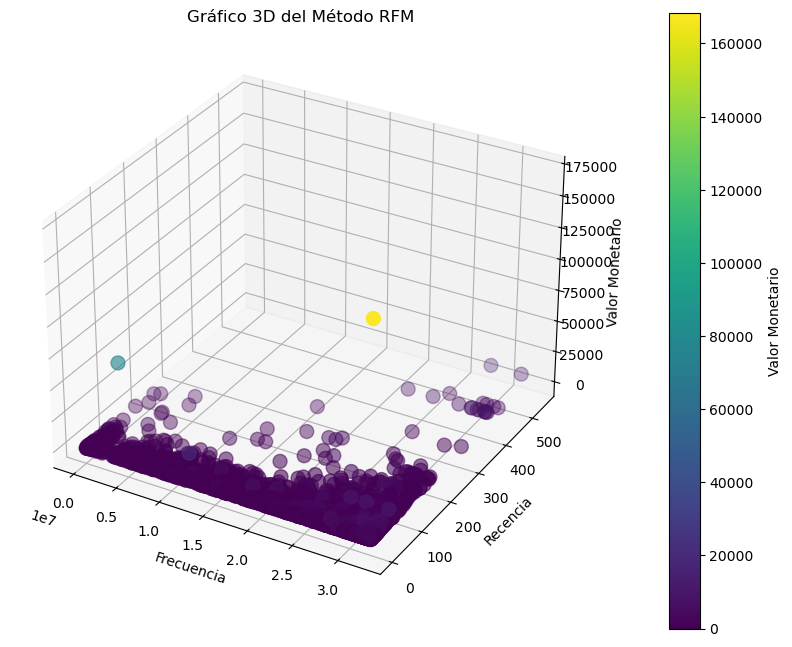

In [39]:
import pandas as pd
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

# Crear un gráfico 3D
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')

# Agregar puntos al gráfico
scatter = ax.scatter(
    df_pandas["c_reciente"],   # Eje X
    df_pandas["frecuencia"],     # Eje Y
    df_pandas["ComprasTotales"],  # Eje Z
    c=df_pandas["ComprasTotales"], cmap="viridis", s=100
)

# Etiquetas de los ejes
ax.set_xlabel("Frecuencia")
ax.set_ylabel("Recencia")
ax.set_zlabel("Valor Monetario")

# Agregar barra de color
cbar = fig.colorbar(scatter, ax=ax, pad=0.1)
cbar.set_label("Valor Monetario")

# Título del gráfico
ax.set_title("Gráfico 3D del Método RFM")

# Mostrar el gráfico
plt.show()

## MACHINE LEARNING: K-MEANS

La idea de K-MEANS, es agrupar los datos con similares características. Con el fin de encontrar patrones en los datos, sin la necesidad de etiquetas. 

**PASO 1**: Elegir el número correcto de clústeres.

En este caso, para elegir el número correcto de clústeres, se usará la técnica del codo. La cual, se basa en generar una curva de la suma de los errores al cuadrado, para minimizar la inercia y el número de clústeres (K).

In [40]:
# En primera instacia, se procede a generar el codo.
from pyspark.ml.clustering import KMeans
from pyspark.ml.evaluation import ClusteringEvaluator
import numpy as np

#Crear una matriz de zeros de 10x10
costo = np.zeros(10)

# Evalúa la calidad de los clústeres generados. En este caso, usa la métrica de silhouette.
# La columna predicción, contiene las etiquetas asignadas por el modelo.
evaluator = ClusteringEvaluator(predictionCol='prediccion', featuresCol='estandarizado',metricName='silhouette', distanceMeasure='squaredEuclidean')

# Bucle para probar valores, desde 2 hasta 10. (El algoritmo no permite K = 1)
for i in range(2,10):
    KMedias = KMeans(featuresCol='estandarizado', k=i)
    KMedias_fit = KMedias.fit(salida_datos_escalados)
    output = KMedias_fit.transform(salida_datos_escalados)
    costo[i] = KMedias_fit.summary.trainingCost

In [41]:
# Creando un dataset para proceder a graficarlos
import pandas as pd
df_cost = pd.DataFrame(costo[2:])
df_cost.columns = ["costo"]
new_col = range(2,10)
df_cost.insert(0, 'cluster', new_col)
print(df_cost)

   cluster         costo
0        2  10366.514562
1        3   6774.433838
2        4   4193.344364
3        5   3450.525482
4        6   2949.466455
5        7   2009.418509
6        8   1523.139337
7        9   1347.157202


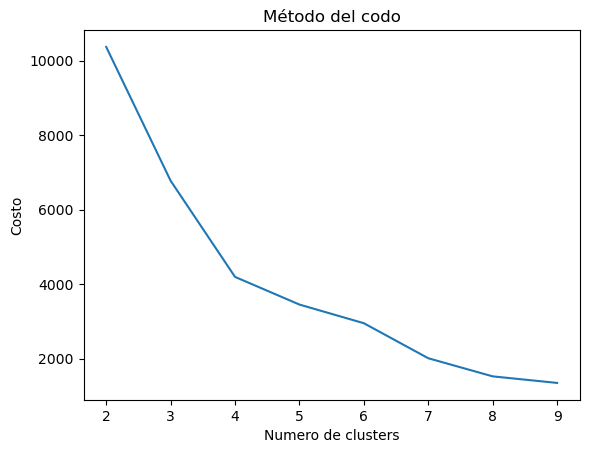

In [42]:
# Graficando el codo

import pandas as pd
import matplotlib.pyplot as plt

plt.plot(df_cost.cluster, df_cost.costo)
plt.title('Método del codo')
plt.xlabel('Numero de clusters')
plt.ylabel('Costo')
plt.show()

**PASO 2:** Creando el modelo K-MEANS
Se visualiza que el clúster óptimo es 4

In [43]:
Algorit_KMeans = KMeans(featuresCol='estandarizado', k=4)
KMeans_fit = Algorit_KMeans.fit(salida_datos_escalados)

**Visualización de los cluster**
Para esto, se usa el DataFrame df_pandas

In [51]:
import pandas as pd
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

df_rfm = df_pandas

df_rfm.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4724 entries, 0 to 4723
Data columns (total 5 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   c_reciente      4724 non-null   int64  
 1   frecuencia      4724 non-null   int64  
 2   ComprasTotales  4724 non-null   float64
 3   CustomerId      4724 non-null   object 
 4   Cluster         4724 non-null   int32  
dtypes: float64(1), int32(1), int64(2), object(1)
memory usage: 166.2+ KB


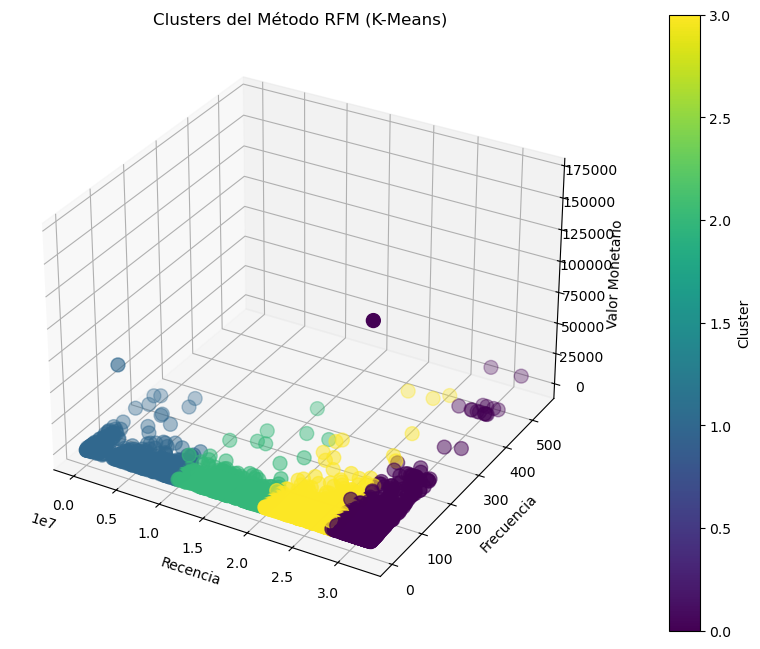

In [73]:
# Aplicar K-Means para segmentación
kmeans = KMeans(n_clusters=4, random_state=0)  # Elegir el número de clusters
df_rfm["Cluster"] = kmeans.fit_predict(df_rfm)

# Crear un gráfico 3D
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')

# Añadir puntos al gráfico
scatter = ax.scatter(df_rfm["c_reciente"], df_rfm["frecuencia"], df_rfm["ComprasTotales"], c=df_rfm["Cluster"], cmap="viridis", s=100)

# Etiquetas de los ejes
ax.set_xlabel("Recencia")
ax.set_ylabel("Frecuencia")
ax.set_zlabel("Valor Monetario")

# Añadir una barra de colores para los clusters
cbar = fig.colorbar(scatter, ax=ax, pad=0.1)
cbar.set_label("Cluster")

# Título del gráfico
ax.set_title("Clusters del Método RFM (K-Means)")

# Mostrar el gráfico
plt.show()

**PASO 3:** Asignación de clientes en clústeres

In [81]:
prediccion = KMeans_fit.transform(salida_datos_escalados)
prediccion.show(5,0)

+----------+----------+--------------+----------+---------------------+--------------------------------------------------------------+----------+
|c_reciente|frecuencia|ComprasTotales|CustomerId|caracteristicas      |estandarizado                                                 |prediction|
+----------+----------+--------------+----------+---------------------+--------------------------------------------------------------+----------+
|31044660  |1         |0.00          |13256     |[3.104466E7,1.0,0.0] |[3.5769304537440645,0.02524151595200202,0.0]                  |0         |
|28437240  |1         |1.00          |16454     |[2.843724E7,1.0,1.0] |[3.2765064837697966,0.02524151595200202,3.5686405018316945E-4]|0         |
|22213680  |2         |1.80          |16272     |[2.221368E7,2.0,1.8] |[2.559434971480617,0.05048303190400404,6.42355290329705E-4]   |0         |
|31030140  |1         |2.10          |15872     |[3.103014E7,1.0,2.1] |[3.575257475840993,0.02524151595200202,7.494145053846

## ANÁLISIS DE LOS RESULTADOS

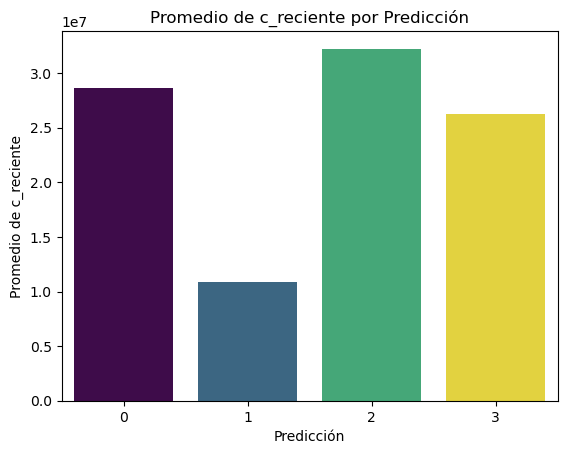

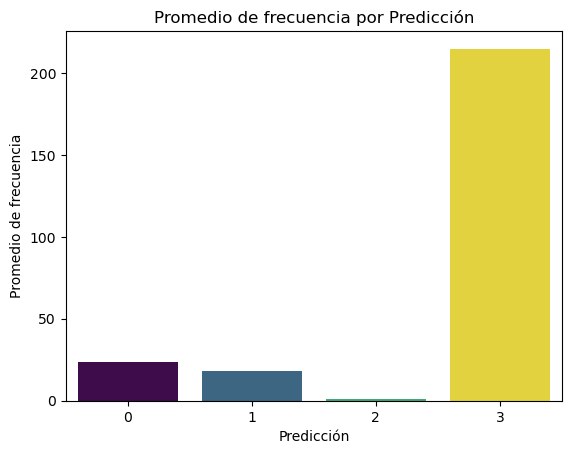

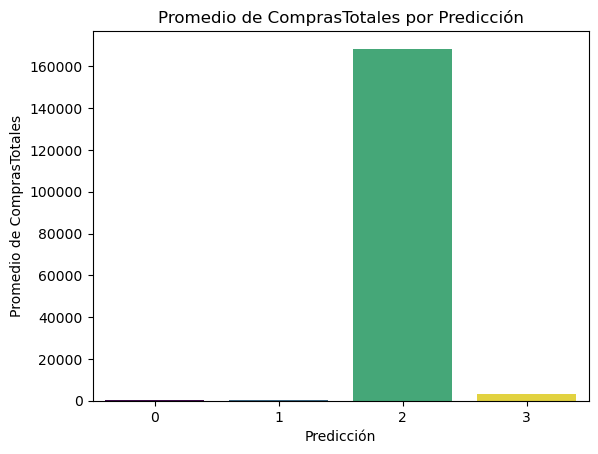

In [83]:
import matplotlib.pyplot as plt
import seaborn as sns

df_barr = prediccion.select('c_reciente','frecuencia','ComprasTotales','prediction')
df_barr = df_barr.toPandas()
df_prom = df_barr.groupby(['prediction'], as_index=False).mean()

list1 = ['c_reciente','frecuencia','ComprasTotales']

for i in list1:
    sns.barplot(
        x='prediction', 
        y=i, 
        data=avg_df, 
        hue='prediction',  # Asignar 'prediction' a `hue` para los colores
        palette="viridis", 
        legend=False  # No mostrar leyenda, si no es necesaria
        )
    plt.title(f"Promedio de {i} por Predicción")
    plt.xlabel("Predicción")
    plt.ylabel(f"Promedio de {i}")
    plt.show()

**ANÁLISIS:**
* Se puede observar que en el clúster 0, los usuarios realizan compras recientes, sin mucha frecuencia, y las compras totales no son amplias.
* Para el caso del clúster 1, los usuarios, no realizan muchas compras recientes, tienen una baja frecuencia y las compras totales no son muy amplias.
* Para el clúster 2, se observa que existen muchas compras recientes, no tienen mucha frecuencia, debido al hecho que son recientes y las compras totales, han sido altas.
* Para el caso del clúster 3, se observa que existen muchas compras recientes, con mucha frecuencia y un bajo valor monetario.
* En la figura de la distribución del clúster, se observa que existen datos que están muy elevados, en su valor monetario (Compras totales), en este caso, sería un dato a analizar para un posible retiro dependiendo el caso.
* Se puede apreciar, que es necesario algunas ocasiones pasar el DataSet a Pandas para mostrar gráficos.

**BIBLIOGRAFÍA**
* Géron, A. (2019). Hands-on machine learning with Scikit-Learn, Keras, and TensorFlow: Concepts, tools, and techniques to build intelligent systems (2nd ed.). O'Reilly Media.
* Tutorial PySpark, DataCamp, https://www.datacamp.com/es/tutorial/pyspark-tutorial-getting-started-with-pyspark
* Dataset: https://archive.ics.uci.edu/dataset/352/online+retail
* Curso Frogames, Machine Learning de la A a la Z, https://cursos.frogamesformacion.com/courses/machine-learning-az